ROI Analysis

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from statsmodels.stats.anova import AnovaRM
from scipy.stats import wilcoxon, ttest_rel, ttest_ind, ttest_1samp
from statsmodels.stats.multitest import multipletests

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Helper Functions
def partial_eta_squared(aov):
    """Calculate partial eta-squared for ANOVA results."""
    aov = aov.copy()
    aov['pes'] = (aov['Num DF'] * aov['F Value']) / (aov['Num DF'] * aov['F Value'] + aov['Den DF'])
    return aov

def analyze_roi_data(data, experiment='exp1'):
    """Analyze ROI data with multiple comparison correction."""
    results = {}
    all_tests = []
    
    if experiment == 'exp1':
        conditions = ['object', 'scramble']
        rois = ['LO', 'pIPS']
    else:
        conditions = ['tool', 'nontool']
        rois = ['PFS', 'aIPS', 'LO', 'pIPS']
        
    for roi in rois:
        for hemi in ['left', 'right']:
            roi_data = data[(data['roi'] == roi) & (data['hemi'] == hemi)]
            cond1_data = roi_data[roi_data['cond'] == conditions[0]]['mean_act'].values
            cond2_data = roi_data[roi_data['cond'] == conditions[1]]['mean_act'].values
            
            # Calculate statistics
            t_stat, p_val = ttest_rel(cond1_data, cond2_data)
            mean_diff = np.mean(cond1_data - cond2_data)
            se_diff = np.std(cond1_data - cond2_data) / np.sqrt(len(cond1_data))
            d = mean_diff / np.sqrt((np.std(cond1_data)**2 + np.std(cond2_data)**2) / 2)
            
            # Store results
            all_tests.append({
                'roi': f'{hemi}_{roi}',
                'p_value': p_val,
                't_stat': t_stat,
                'mean_diff': mean_diff,
                'se': se_diff,
                'cohens_d': d,
                'n': len(cond1_data),
                f'mean_{conditions[0]}': np.mean(cond1_data),
                f'mean_{conditions[1]}': np.mean(cond2_data)
            })
    
    # Apply Holm-Bonferroni correction
    p_values = [test['p_value'] for test in all_tests]
    _, p_corrected, _, _ = multipletests(p_values, method='holm')
    
    # Update results with corrected p-values
    for test, p_corr in zip(all_tests, p_corrected):
        results[test['roi']] = test
        results[test['roi']]['p_corrected'] = p_corr
    
    return results

def run_rmanova(data, factors):
    """Run repeated measures ANOVA with effect sizes."""
    aov = AnovaRM(data=data, 
                  depvar='mean_act',
                  subject='sub',
                  within=factors).fit()
    
    aov_table = partial_eta_squared(aov.anova_table)
    return aov_table

In [4]:
# Load Data
# Experiment 1
exp1_results = pd.read_csv("/user_data/csimmon2/git_repos/ptoc/results/selectivity/selectivity_summary.csv")

filtered_exp1 = exp1_results[(exp1_results['group'] == 'control') & 
                            (exp1_results['roi'].isin(['LO', 'pIPS'])) &
                            (exp1_results['sub'] != 'sub-084')]

# Experiment 2
exp2_results = pd.read_csv("/user_data/csimmon2/git_repos/ptoc/results/tools/selectivity/selectivity_summarytoolloc.csv")
filtered_exp2 = exp2_results[exp2_results['sub'].str.contains('spaceloc')]

ROI Analysis

In [4]:
# Experiment 1 ROI Analysis
# Full ANOVA
exp1_anova = run_rmanova(filtered_exp1, ['roi', 'hemi', 'cond'])
print("Experiment 1 ANOVA Results:")
print(exp1_anova)

# ROI Analysis
exp1_roi_results = analyze_roi_data(filtered_exp1, 'exp1')
print("\nExperiment 1 ROI Results:")
for roi, stats in exp1_roi_results.items():
    print(f"\n{roi}:")
    print(f"t({stats['n']-1}) = {stats['t_stat']:.3f}, p = {stats['p_value']:.4f}, p_corr = {stats['p_corrected']:.4f}")
    print(f"Cohen's d = {stats['cohens_d']:.3f}")
    print(f"Mean difference = {stats['mean_diff']:.3f} ± {stats['se']:.3f}")

Experiment 1 ANOVA Results:
                  F Value  Num DF  Den DF        Pr > F       pes
roi             39.763898     1.0    17.0  7.897722e-06  0.700514
hemi            10.301246     1.0    17.0  5.140748e-03  0.377318
cond            55.387486     1.0    17.0  9.623988e-07  0.765153
roi:hemi         2.803147     1.0    17.0  1.123766e-01  0.141551
roi:cond       108.745714     1.0    17.0  8.346158e-09  0.864807
hemi:cond        2.746805     1.0    17.0  1.157867e-01  0.139101
roi:hemi:cond    0.056390     1.0    17.0  8.151334e-01  0.003306


NameError: name 'ttest_rel' is not defined

In [5]:
# Experiment 2 ROI Analysis
# Full ANOVA
exp2_anova = run_rmanova(filtered_exp2, ['roi', 'hemi', 'cond'])
print("Experiment 2 ANOVA Results:")
print(exp2_anova)

# ROI Analysis
exp2_roi_results = analyze_roi_data(filtered_exp2, 'exp2')
print("\nExperiment 2 ROI Results:")
for roi, stats in exp2_roi_results.items():
    print(f"\n{roi}:")
    print(f"t({stats['n']-1}) = {stats['t_stat']:.3f}, p = {stats['p_value']:.4f}, p_corr = {stats['p_corrected']:.4f}")
    print(f"Cohen's d = {stats['cohens_d']:.3f}")
    print(f"Mean difference = {stats['mean_diff']:.3f} ± {stats['se']:.3f}")



Experiment 2 ANOVA Results:
                 F Value  Num DF  Den DF        Pr > F       pes
roi            69.788835     3.0    51.0  4.595074e-18  0.804122
hemi           25.586962     1.0    17.0  9.700100e-05  0.600817
cond            1.697378     1.0    17.0  2.100038e-01  0.090782
roi:hemi        1.617712     3.0    51.0  1.967325e-01  0.086891
roi:cond       23.018004     3.0    51.0  1.468259e-09  0.575191
hemi:cond      15.531839     1.0    17.0  1.053597e-03  0.477435
roi:hemi:cond   1.616753     3.0    51.0  1.969531e-01  0.086844


NameError: name 'ttest_rel' is not defined

In [ ]:
# explaining roi creation
from nilearn import plotting, datasets
import nibabel as nib

# Load each parcel
parcel_lo = nib.load('roiParcels/LO.nii.gz')
parcel_pips = nib.load('roiParcels/pIPS.nii.gz')
parcel_aips = nib.load('roiParcels/aIPS.nii.gz')

# Plot each Julian/Mruczek parcel with colors
plotting.plot_stat_map(parcel_lo, title="LO Parcel", colorbar=False, cmap='Reds', threshold=0.1)
plotting.plot_stat_map(parcel_pips, title="pIPS Parcel", colorbar=False, cmap='Blues', threshold=0.1)
plotting.plot_stat_map(parcel_aips, title="aIPS Parcel", colorbar=False, cmap='Greens', threshold=0.1)

plotting.show()

FC and PPI Connectivity Analysis

In [19]:
# Simple FC Analysis (Nonparametric)
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

# Load data
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
data_df = pd.read_csv(f"{results_dir}/fc_ppi/matchvlad_seed_target_activations.csv")
fc_data = data_df[data_df['analysis'] == 'fc']

# 1. Test if connections are significantly different from zero
all_tests = []

for name, group in fc_data.groupby(['seed_hemisphere', 'target_hemisphere']):
    seed_hemi, target_hemi = name
    conn_values = group['mean_activation'].values
    
    # One-sample Wilcoxon signed-rank test against zero
    w_stat, p_val = wilcoxon(conn_values)
    
    all_tests.append({
        'connection': f"{seed_hemi} to {target_hemi}",
        'p_val': p_val,
        'w_stat': w_stat,
        'mean': np.mean(conn_values),
        'sem': np.std(conn_values, ddof=1) / np.sqrt(len(conn_values))
    })
    
    print(f"\n{seed_hemi} to {target_hemi}:")
    print(f"Mean = {np.mean(conn_values):.4f} ± {np.std(conn_values, ddof=1) / np.sqrt(len(conn_values)):.4f}")
    print(f"W = {w_stat:.1f}, p = {p_val:.6f}")

# Apply Holm-Bonferroni correction
p_values = [test['p_val'] for test in all_tests]
_, p_corrected = multipletests(p_values, method='holm')[:2]

print("\nHolm-Bonferroni corrected results:")
for i, test in enumerate(all_tests):
    print(f"{test['connection']}: p = {p_corrected[i]:.6f}")

# 2. Compare ipsilateral vs contralateral connections
# Define ipsilateral connections
ipsi = fc_data[
    ((fc_data['seed_hemisphere'] == 'left') & (fc_data['target_hemisphere'] == 'left')) |
    ((fc_data['seed_hemisphere'] == 'right') & (fc_data['target_hemisphere'] == 'right'))
]['mean_activation']

# Define contralateral connections
contra = fc_data[
    ((fc_data['seed_hemisphere'] == 'left') & (fc_data['target_hemisphere'] == 'right')) |
    ((fc_data['seed_hemisphere'] == 'right') & (fc_data['target_hemisphere'] == 'left'))
]['mean_activation']

# Use paired Wilcoxon test
w_stat, p_val = wilcoxon(ipsi, contra)

print(f"\nIpsilateral vs Contralateral:")
print(f"Mean Ipsilateral = {np.mean(ipsi):.4f} ± {np.std(ipsi, ddof=1) / np.sqrt(len(ipsi)):.4f}")
print(f"Mean Contralateral = {np.mean(contra):.4f} ± {np.std(contra, ddof=1) / np.sqrt(len(contra)):.4f}")
print(f"W = {w_stat:.1f}, p = {p_val:.6f}")

# Add this test to the multiple comparison correction
all_tests.append({
    'connection': "Ipsilateral vs Contralateral",
    'p_val': p_val
})

# Run Holm-Bonferroni on all tests together
all_p_values = [test['p_val'] for test in all_tests]
_, all_p_corrected = multipletests(all_p_values, method='holm')[:2]

# Get the corrected p-value for the ipsi vs contra test (last one added)
ipsi_contra_corrected_p = all_p_corrected[-1]
print(f"Holm-Bonferroni corrected p = {ipsi_contra_corrected_p:.6f}")


left to left:
Mean = 0.1833 ± 0.0145
W = 0.0, p = 0.000004

left to right:
Mean = 0.1637 ± 0.0133
W = 0.0, p = 0.000004

right to left:
Mean = 0.1635 ± 0.0137
W = 0.0, p = 0.000004

right to right:
Mean = 0.1728 ± 0.0135
W = 0.0, p = 0.000004

Holm-Bonferroni corrected results:
left to left: p = 0.000015
left to right: p = 0.000015
right to left: p = 0.000015
right to right: p = 0.000015

Ipsilateral vs Contralateral:
Mean Ipsilateral = 0.1781 ± 0.0098
Mean Contralateral = 0.1636 ± 0.0094
W = 188.0, p = 0.007252
Holm-Bonferroni corrected p = 0.007252


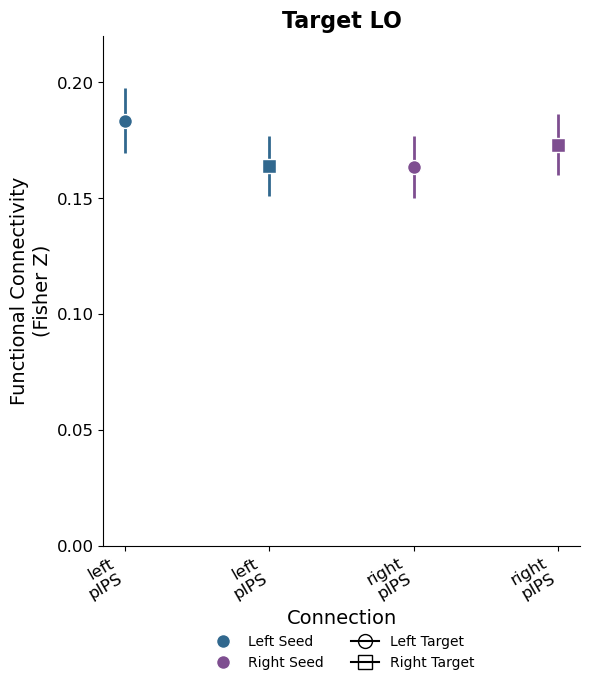

In [29]:
# plot fc data exp 1
import matplotlib.pyplot as plt
import numpy as np

def create_fc_plot(fc_data):
    # Set style params
    plt.style.use('default')
    
    # Create figure with extra space at bottom for legend
    fig, ax = plt.subplots(figsize=(6, 7))
    
    # Define colors and markers
    colors = {'left': '#31688E',  # blue
             'right': '#7E4E90'}  # purple
    markers = {'left': 'o',  # circle
              'right': 's'}  # square
    
    # Calculate means and SEs for each connection
    connections = []
    means = []
    ses = []
    plot_colors = []
    plot_markers = []
    
    for seed_hemi in ['left', 'right']:
        for target_hemi in ['left', 'right']:
            curr_data = fc_data[
                (fc_data['seed_hemisphere'] == seed_hemi) &
                (fc_data['target_hemisphere'] == target_hemi)
            ]['mean_activation']
            connections.append(f"{seed_hemi}\npIPS")
            means.append(np.mean(curr_data))
            ses.append(np.std(curr_data) / np.sqrt(len(curr_data)))
            plot_colors.append(colors[seed_hemi])
            plot_markers.append(markers[target_hemi])
    
    # Plot
    x = np.arange(len(connections))
    
    # Error bars and points
    for i, (mean, se, color, marker) in enumerate(zip(means, ses, plot_colors, plot_markers)):
        plt.errorbar(i, mean, yerr=se, fmt='none', color=color,
                    capsize=0, capthick=1, elinewidth=2)
        plt.scatter(i, mean, color=color, marker=marker, s=100,
                   edgecolor='white', linewidth=1, zorder=3)
    
    # Create legend elements
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['left'],
               label='Left Seed', markersize=10, markeredgecolor='white'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['right'],
               label='Right Seed', markersize=10, markeredgecolor='white'),
        Line2D([0], [0], marker='o', color='black',
               label='Left Target', markersize=10, markerfacecolor='none'),
        Line2D([0], [0], marker='s', color='black',
               label='Right Target', markersize=10, markerfacecolor='none')
    ]
    
    # Add legend below the plot
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15),
             ncol=2, frameon=False)
    
    # Styling
    plt.xticks(x, connections, rotation=30, ha='right')
    plt.ylabel('Functional Connectivity\n(Fisher Z)', fontsize=14)
    plt.xlabel('Connection', fontsize=14)
    plt.title('Target LO', fontsize=16, fontweight='bold')
    
    # Set y-axis minimum to 0 and fewer ticks
    ax.set_ylim(bottom=0, top=0.22)
    ax.set_yticks(np.arange(0, 0.21, 0.05))  # Set ticks at 0, 0.05, 0.10, 0.15, 0.20
    
    # Theme
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    return fig

# Run plot
plot = create_fc_plot(fc_data)
plt.show()

/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/nilearn/__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()
/home/csimmon2/anaconda3/envs/brainiak_env/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


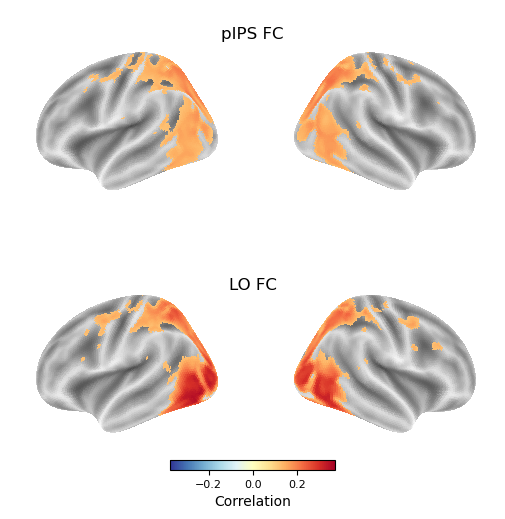

In [ ]:
# FC Figure || not used in final

# Functional Connectivity Group Averages - Inflated Surface Maps
### NOTE THAT LEFT SHOWS LEFT SEED TO LEFT HEMISPHERE RIGHT SHOWS RIGHT SEED TO RIGHT HEMISPHERE
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, plotting, datasets, surface
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

def plot_inflated_brains(out_dir, rois, hemispheres):
    # Get fsaverage surface data
    fsaverage = datasets.fetch_surf_fsaverage()
    
    # First pass to determine global max across all ROIs
    global_vmax = 0
    for roi in rois:
        for analysis_type in ['fc']:  
            for hemi in hemispheres:
                img_file = f'{out_dir}/{roi}_{hemi}_{analysis_type}_avg.nii.gz'
                if os.path.exists(img_file):
                    img = nib.load(img_file)
                    data = img.get_fdata()
                    global_vmax = max(global_vmax, np.abs(data).max())

    # Create a single figure for all views
    fig = plt.figure(figsize=(5.5, 5))
    
    # Create 2x2 grid of 3D axes
    ax1 = fig.add_subplot(221, projection='3d')  # Top left - pIPS left lateral
    ax2 = fig.add_subplot(222, projection='3d')  # Top right - pIPS right lateral
    ax3 = fig.add_subplot(223, projection='3d')  # Bottom left - LO left lateral
    ax4 = fig.add_subplot(224, projection='3d')  # Bottom right - LO right lateral
    
    # Add row titles
    fig.text(0.5, 0.92, 'pIPS FC', va='center', ha='center', fontsize=12)
    fig.text(0.5, 0.42, 'LO FC', va='center', ha='center', fontsize=12)

    '''
    # Set titles
    ax1.set_title('pIPS left', pad=0)  # Reduced padding to match original
    ax2.set_title('pIPS right', pad=0)
    ax3.set_title('LO left', pad=0)
    ax4.set_title('LO right', pad=0)
    '''
    
    # Process each ROI and hemisphere
    for roi_idx, roi in enumerate(rois):
        for hemi_idx, hemi in enumerate(hemispheres):
            img_file = f'{out_dir}/{roi}_{hemi}_fc_avg.nii.gz'
            if os.path.exists(img_file):
                img = nib.load(img_file)
                surf_data = surface.vol_to_surf(img, fsaverage.pial_left if hemi == 'left' else fsaverage.pial_right)
                
                # Determine which axis to use
                ax = [ax1, ax2, ax3, ax4][roi_idx * 2 + hemi_idx]
                
                # Plot lateral view
                plotting.plot_surf_stat_map(
                    surf_mesh=fsaverage.infl_left if hemi == 'left' else fsaverage.infl_right,
                    stat_map=surf_data,
                    hemi=hemi,
                    view='lateral',
                    bg_map=fsaverage.sulc_left if hemi == 'left' else fsaverage.sulc_right,
                    colorbar=False, #title=f'{roi} {hemi} {analysis_type.upper()}',
                    cmap='RdYlBu_r',
                    axes=ax,
                    threshold=0.12,
                    vmax=global_vmax
                )
    
    # Add colorbar at the bottom center
    norm = Normalize(vmin=-global_vmax, vmax=global_vmax)
    sm = ScalarMappable(cmap='RdYlBu_r', norm=norm)
    sm.set_array([])
    
    # Create a new axes for the colorbar at the bottom center
    cbar_ax = fig.add_axes([0.35, 0.05, 0.3, 0.02])  # [left, bottom, width, height]
    plt.colorbar(sm, cax=cbar_ax, orientation='horizontal', label='Correlation')
    cbar_ax.tick_params(labelsize=8)  # Smaller font size
    
    plt.tight_layout()
    plt.show()

def main():
    study = 'ptoc'
    study_dir = f"/lab_data/behrmannlab/vlad/{study}"
    results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
    
    group_out_dir = f'{results_dir}/group_averages'
    os.makedirs(group_out_dir, exist_ok=True)
    
    rois = ['pIPS', 'LO']
    hemispheres = ['left', 'right']
    
    plot_inflated_brains(group_out_dir, rois, hemispheres)

if __name__ == "__main__":
    main()

In [ ]:
# FC Analysis (Experiment 2)

In [5]:
# corrected ppi stats
# Streamlined PPI Analysis (Nonparametric)
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings('ignore')

# Load data
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
data_df = pd.read_csv(f"{results_dir}/fc_ppi/matchvlad_seed_target_activations.csv")
ppi_data = data_df[data_df['analysis'] == 'ppi']

print("PPI Analysis Results:")
print("=" * 50)

# 1. Test if connections are significantly different from zero
all_tests = []

for name, group in ppi_data.groupby(['seed_hemisphere', 'target_hemisphere']):
    seed_hemi, target_hemi = name
    conn_values = group['mean_activation'].values
    
    # One-sample Wilcoxon signed-rank test against zero
    w_stat, p_val = wilcoxon(conn_values)
    
    # Calculate effect size (Cohen's d for one-sample)
    d = np.mean(conn_values) / (np.std(conn_values, ddof=1) + 1e-10)
    
    all_tests.append({
        'connection': f"{seed_hemi} to {target_hemi}",
        'p_val': p_val,
        'w_stat': w_stat,
        'd': d,
        'mean': np.mean(conn_values),
        'sem': np.std(conn_values, ddof=1) / np.sqrt(len(conn_values))
    })
    
    print(f"\n{seed_hemi} to {target_hemi}:")
    print(f"Mean = {np.mean(conn_values):.4f} ± {np.std(conn_values, ddof=1) / np.sqrt(len(conn_values)):.4f}")
    print(f"W = {w_stat:.1f}, p = {p_val:.6f}, d = {d:.3f}")

# Apply Holm-Bonferroni correction
p_values = [test['p_val'] for test in all_tests]
_, p_corrected = multipletests(p_values, method='holm')[:2]

print("\nHolm-Bonferroni corrected results:")
for i, test in enumerate(all_tests):
    print(f"{test['connection']}: p = {p_corrected[i]:.6f}")
    print(f"  SIGNIFICANT" if p_corrected[i] < 0.05 else "  Not significant")

# 2. Compare ipsilateral vs contralateral connections
# Define ipsilateral connections
ipsi = ppi_data[
    ((ppi_data['seed_hemisphere'] == 'left') & (ppi_data['target_hemisphere'] == 'left')) |
    ((ppi_data['seed_hemisphere'] == 'right') & (ppi_data['target_hemisphere'] == 'right'))
]['mean_activation']

# Define contralateral connections
contra = ppi_data[
    ((ppi_data['seed_hemisphere'] == 'left') & (ppi_data['target_hemisphere'] == 'right')) |
    ((ppi_data['seed_hemisphere'] == 'right') & (ppi_data['target_hemisphere'] == 'left'))
]['mean_activation']

# Use paired Wilcoxon test
w_stat, p_val = wilcoxon(ipsi, contra)

# Calculate effect size (Cohen's d for paired samples)
diff = ipsi.values - contra.values
d = np.mean(diff) / (np.std(diff, ddof=1) + 1e-10)

print(f"\nIpsilateral vs Contralateral:")
print(f"Mean Ipsilateral = {np.mean(ipsi):.4f} ± {np.std(ipsi, ddof=1) / np.sqrt(len(ipsi)):.4f}")
print(f"Mean Contralateral = {np.mean(contra):.4f} ± {np.std(contra, ddof=1) / np.sqrt(len(contra)):.4f}")
print(f"W = {w_stat:.1f}, p = {p_val:.6f}, d = {d:.3f}")

# Add this test to the multiple comparison correction
all_tests.append({
    'connection': "Ipsilateral vs Contralateral",
    'p_val': p_val,
    'w_stat': w_stat,
    'd': d
})

# Run Holm-Bonferroni on all tests together
all_p_values = [test['p_val'] for test in all_tests]
_, all_p_corrected = multipletests(all_p_values, method='holm')[:2]

# Get the corrected p-value for the ipsi vs contra test (last one added)
ipsi_contra_corrected_p = all_p_corrected[-1]
print(f"Holm-Bonferroni corrected p = {ipsi_contra_corrected_p:.6f}")
print(f"  SIGNIFICANT" if ipsi_contra_corrected_p < 0.05 else "  Not significant")

# 3. Left vs Right comparisons
print("\n3. Left vs Right seed comparisons:")

# Left vs Right pIPS seeds
left_pips = ppi_data[ppi_data['seed_hemisphere'] == 'left']['mean_activation']
right_pips = ppi_data[ppi_data['seed_hemisphere'] == 'right']['mean_activation']
w_stat_seed, p_val_seed = wilcoxon(left_pips, right_pips)

# Calculate effect size
diff_seed = left_pips.values - right_pips.values
d_seed = np.mean(diff_seed) / (np.std(diff_seed, ddof=1) + 1e-10)

print(f"\nLeft vs Right pIPS seeds:")
print(f"Mean Left = {np.mean(left_pips):.4f} ± {np.std(left_pips, ddof=1) / np.sqrt(len(left_pips)):.4f}")
print(f"Mean Right = {np.mean(right_pips):.4f} ± {np.std(right_pips, ddof=1) / np.sqrt(len(right_pips)):.4f}")
print(f"W = {w_stat_seed:.1f}, p = {p_val_seed:.6f}, d = {d_seed:.3f}")

# Left vs Right LO targets
left_lo = ppi_data[ppi_data['target_hemisphere'] == 'left']['mean_activation']
right_lo = ppi_data[ppi_data['target_hemisphere'] == 'right']['mean_activation']
w_stat_target, p_val_target = wilcoxon(left_lo, right_lo)

# Calculate effect size
diff_target = left_lo.values - right_lo.values
d_target = np.mean(diff_target) / (np.std(diff_target, ddof=1) + 1e-10)

print(f"\nLeft vs Right LO targets:")
print(f"Mean Left = {np.mean(left_lo):.4f} ± {np.std(left_lo, ddof=1) / np.sqrt(len(left_lo)):.4f}")
print(f"Mean Right = {np.mean(right_lo):.4f} ± {np.std(right_lo, ddof=1) / np.sqrt(len(right_lo)):.4f}")
print(f"W = {w_stat_target:.1f}, p = {p_val_target:.6f}, d = {d_target:.3f}")

# Add these tests to the correction
all_tests.append({
    'connection': "Left vs Right pIPS seeds",
    'p_val': p_val_seed,
    'w_stat': w_stat_seed,
    'd': d_seed
})

all_tests.append({
    'connection': "Left vs Right LO targets",
    'p_val': p_val_target,
    'w_stat': w_stat_target,
    'd': d_target
})

# Final correction for all tests
final_p_values = [test['p_val'] for test in all_tests]
_, final_p_corrected = multipletests(final_p_values, method='holm')[:2]

print("\nFinal Holm-Bonferroni corrections:")
for i, test in enumerate(all_tests):
    if i >= len(all_tests) - 3:  # Only show the last 3 tests (ipsi vs contra, left vs right seed, left vs right target)
        print(f"{test['connection']}: corrected p = {final_p_corrected[i]:.6f}")
        print(f"  SIGNIFICANT" if final_p_corrected[i] < 0.05 else "  Not significant")

PPI Analysis Results:

left to left:
Mean = 0.0351 ± 0.0062
W = 3.0, p = 0.000019, d = 1.305

left to right:
Mean = 0.0310 ± 0.0063
W = 12.0, p = 0.000267, d = 1.125

right to left:
Mean = 0.0279 ± 0.0058
W = 13.0, p = 0.000336, d = 1.107

right to right:
Mean = 0.0229 ± 0.0054
W = 20.0, p = 0.001411, d = 0.977

Holm-Bonferroni corrected results:
left to left: p = 0.000076
  SIGNIFICANT
left to right: p = 0.000801
  SIGNIFICANT
right to left: p = 0.000801
  SIGNIFICANT
right to right: p = 0.001411
  SIGNIFICANT

Ipsilateral vs Contralateral:
Mean Ipsilateral = 0.0290 ± 0.0042
Mean Contralateral = 0.0294 ± 0.0042
W = 357.0, p = 0.852178, d = -0.040
Holm-Bonferroni corrected p = 0.852178
  Not significant

3. Left vs Right seed comparisons:

Left vs Right pIPS seeds:
Mean Left = 0.0331 ± 0.0044
Mean Right = 0.0254 ± 0.0039
W = 183.0, p = 0.005714, d = 0.413

Left vs Right LO targets:
Mean Left = 0.0315 ± 0.0042
Mean Right = 0.0269 ± 0.0041
W = 208.0, p = 0.017571, d = 0.452

Final Holm-B

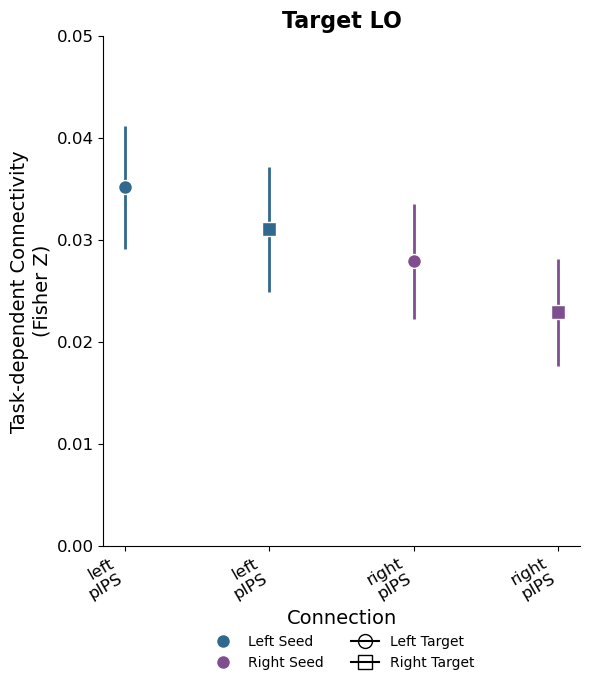

In [27]:
# Plot PPI data exp 1
import numpy as np

def create_ppi_plot(ppi_data):
    # Set style params
    plt.style.use('default')
    
    # Create figure with extra space for legend
    fig, ax = plt.subplots(figsize=(6, 7))
    
    # Define colors and markers
    colors = {'left': '#31688E',  # blue
             'right': '#7E4E90'}  # purple
    markers = {'left': 'o',  # circle
              'right': 's'}  # square
    
    # Calculate means and SEs for each connection
    connections = []
    means = []
    ses = []
    plot_colors = []
    plot_markers = []
    
    for seed_hemi in ['left', 'right']:
        for target_hemi in ['left', 'right']:
            curr_data = ppi_data[
                (ppi_data['seed_hemisphere'] == seed_hemi) &
                (ppi_data['target_hemisphere'] == target_hemi) &
                (ppi_data['analysis'] == 'ppi')
            ]['mean_activation']
            connections.append(f"{seed_hemi}\npIPS")
            means.append(np.mean(curr_data))
            ses.append(np.std(curr_data) / np.sqrt(len(curr_data)))
            plot_colors.append(colors[seed_hemi])
            plot_markers.append(markers[target_hemi])
    
    # Plot
    x = np.arange(len(connections))
    
    # Error bars and points
    for i, (mean, se, color, marker) in enumerate(zip(means, ses, plot_colors, plot_markers)):
        plt.errorbar(i, mean, yerr=se, fmt='none', color=color,
                    capsize=0, capthick=1, elinewidth=2)
        plt.scatter(i, mean, color=color, marker=marker, s=100,
                   edgecolor='white', linewidth=1, zorder=3)
    
    # Create legend elements
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['left'],
               label='Left Seed', markersize=10, markeredgecolor='white'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=colors['right'],
               label='Right Seed', markersize=10, markeredgecolor='white'),
        Line2D([0], [0], marker='o', color='black',
               label='Left Target', markersize=10, markerfacecolor='none'),
        Line2D([0], [0], marker='s', color='black',
               label='Right Target', markersize=10, markerfacecolor='none')
    ]
    
    # Add legend below the plot
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15),
             ncol=2, frameon=False)
    
    # Styling
    plt.xticks(x, connections, rotation=30, ha='right')
    plt.ylabel('Task-dependent Connectivity\n(Fisher Z)', fontsize=14)
    plt.xlabel('Connection', fontsize=14)
    plt.title('Target LO', fontsize=16, fontweight='bold')
    
    # Set y-axis scale with tighter limits
    # Add just a bit of padding above and below the data
    data_range = max(means) - min(means)
    padding = data_range * 0.1  # 10% padding
    ymin = max(-0.05, min(means) - padding)  # Don't go below -0.05 if data doesn't warrant it
    ymax = max(means) + padding
    
    ax.set_ylim(ymin, ymax)
    ax.set_yticks(np.arange(np.floor(ymin*20)/20, ymax+0.02, 0.01))  # Ticks every 0.05
    
    # Theme
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    return fig

# Run plot
plot = create_ppi_plot(data_df)
plt.show()

In [10]:
# Combined PPI (Experiment 2)
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
import warnings
warnings.filterwarnings('ignore')

# Directories
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
output_dir = f'{curr_dir}/tools'
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

def calculate_effect_size(data1, data2=None):
    """Calculate effect size for one-sample or two-sample data"""
    if data2 is None:  # one-sample
        return np.mean(data1) / (np.std(data1, ddof=1) + 1e-10)
    else:  # two-sample
        diff = np.mean(data1) - np.mean(data2)
        pooled_std = np.sqrt((np.var(data1, ddof=1) + np.var(data2, ddof=1)) / 2)
        return diff / (pooled_std + 1e-10)

def analyze_ppi_data_nonparametric(data_df):
    """Analyze PPI data using non-parametric tests including condition as a factor"""
    results = {}
    
    # 1. Overall Friedman test including condition
    wide_data = pd.pivot_table(
        data_df,
        values='value',
        index='subject',
        columns=['condition', 'seed_roi', 'seed_hemi', 'target_hemi'],
        aggfunc='first'
    ).dropna()
    
    # Perform Friedman test on all columns (includes condition)
    chi2, friedman_p = stats.friedmanchisquare(*[wide_data[col].values for col in wide_data.columns])
    results['friedman'] = {
        'chi2': chi2,
        'p': friedman_p,
        'df': len(wide_data.columns) - 1,
        'n_subjects': len(wide_data),
        'n_conditions': len(wide_data.columns),
        'conditions': list(wide_data.columns)
    }
    
    # 2. Test each connection against 0 (for both conditions)
    zero_test_results = []
    for condition in ['Tools', 'Nontools']:
        for seed_roi in ['pIPS', 'aIPS']:
            for seed_hemi in ['left', 'right']:
                for target_hemi in ['left', 'right']:
                    subset = data_df[
                        (data_df['condition'] == condition) &
                        (data_df['seed_roi'] == seed_roi) &
                        (data_df['seed_hemi'] == seed_hemi) &
                        (data_df['target_hemi'] == target_hemi)
                    ]['value']
                    
                    w_stat, p_val = stats.wilcoxon(subset)
                    d = calculate_effect_size(subset)
                    
                    zero_test_results.append({
                        'condition': condition,
                        'connection': f"{seed_hemi} {seed_roi} - {target_hemi} LO",
                        'W': w_stat,
                        'p': p_val,
                        'd': d,
                        'mean': np.mean(subset),
                        'sem': stats.sem(subset)
                    })
    
    # Apply FDR correction to all zero-tests together
    zero_test_df = pd.DataFrame(zero_test_results)
    _, zero_test_df['p_fdr'] = fdrcorrection(zero_test_df['p'])
    results['zero_tests'] = zero_test_df
    
    # 3. Compare Tools vs Nontools for each connection
    condition_comparisons = []
    for seed_roi in ['pIPS', 'aIPS']:
        for seed_hemi in ['left', 'right']:
            for target_hemi in ['left', 'right']:
                tools_data = data_df[
                    (data_df['condition'] == 'Tools') &
                    (data_df['seed_roi'] == seed_roi) &
                    (data_df['seed_hemi'] == seed_hemi) &
                    (data_df['target_hemi'] == target_hemi)
                ]['value']
                
                nontools_data = data_df[
                    (data_df['condition'] == 'Nontools') &
                    (data_df['seed_roi'] == seed_roi) &
                    (data_df['seed_hemi'] == seed_hemi) &
                    (data_df['target_hemi'] == target_hemi)
                ]['value']
                
                w_stat, p_val = stats.wilcoxon(tools_data, nontools_data)
                d = calculate_effect_size(tools_data, nontools_data)
                
                condition_comparisons.append({
                    'connection': f"{seed_hemi} {seed_roi} - {target_hemi} LO",
                    'W': w_stat,
                    'p': p_val,
                    'd': d,
                    'mean_diff': np.mean(tools_data) - np.mean(nontools_data),
                    'tools_mean': np.mean(tools_data),
                    'tools_sem': stats.sem(tools_data),
                    'nontools_mean': np.mean(nontools_data),
                    'nontools_sem': stats.sem(nontools_data)
                })
    
    # Apply FDR correction to condition comparisons
    condition_comp_df = pd.DataFrame(condition_comparisons)
    _, condition_comp_df['p_fdr'] = fdrcorrection(condition_comp_df['p'])
    results['condition_comparisons'] = condition_comp_df
    
    return results

# Load data
tools_df = pd.read_csv(f"{output_dir}/roi_ppi_sphere_summary_tools.csv")
nontools_df = pd.read_csv(f"{output_dir}/roi_ppi_sphere_summary_nontools.csv")

# Add condition labels
tools_df['condition'] = 'Tools'
nontools_df['condition'] = 'Nontools'
exp2_df = pd.concat([tools_df, nontools_df])

# Run analysis
results = analyze_ppi_data_nonparametric(exp2_df)

# Save and print results
with open(f"{results_dir}/exp2_ppi_stats_summary.txt", 'w') as f:
    # Overall test
    f.write(f"Overall Friedman Test Results:\n")
    f.write(f"χ²({results['friedman']['df']}) = {results['friedman']['chi2']:.3f}, p = {results['friedman']['p']:.3f}\n")
    f.write(f"Number of subjects: {results['friedman']['n_subjects']}\n")
    f.write(f"Number of conditions: {results['friedman']['n_conditions']}\n\n")
    
    # Zero tests by condition
    f.write("Tests against zero:\n")
    f.write(results['zero_tests'].round(3).to_string())
    f.write("\n\n")
    
    # Condition comparisons
    f.write("Tools vs Nontools Comparisons:\n")
    f.write(results['condition_comparisons'].round(3).to_string())

# Print results to console
print(f"\nOverall Friedman Test Results:")
print(f"χ²({results['friedman']['df']}) = {results['friedman']['chi2']:.3f}, p = {results['friedman']['p']:.3f}")
print(f"Number of subjects: {results['friedman']['n_subjects']}")
print(f"Number of conditions: {results['friedman']['n_conditions']}\n")

print("\nTests against zero:")
print(results['zero_tests'].round(3))

print("\nTools vs Nontools Comparisons:")
print(results['condition_comparisons'].round(3))


Overall Friedman Test Results:
χ²(23) = 67.858, p = 0.000
Number of subjects: 18
Number of conditions: 24


Tests against zero:
   condition             connection       W      p      d   mean    sem  p_fdr
0      Tools    left pIPS - left LO   827.0  0.006  0.371  0.013  0.004  0.033
1      Tools   left pIPS - right LO  2011.0  0.004  0.330  0.011  0.003  0.033
2      Tools   right pIPS - left LO  2246.0  0.033  0.226  0.008  0.003  0.087
3      Tools  right pIPS - right LO  1027.0  0.107  0.205  0.008  0.004  0.215
4      Tools    left aIPS - left LO   801.0  0.004  0.348  0.013  0.005  0.033
5      Tools   left aIPS - right LO  2135.0  0.013  0.214  0.009  0.004  0.042
6      Tools   right aIPS - left LO  2080.0  0.008  0.233  0.009  0.004  0.033
7      Tools  right aIPS - right LO  1050.0  0.138  0.180  0.007  0.005  0.246
8   Nontools    left pIPS - left LO  1231.0  0.641  0.061  0.002  0.004  0.684
9   Nontools   left pIPS - right LO  2784.0  0.626  0.046  0.002  0.003  0.684
10

GCA

In [7]:
# exp 1 GCA - Updated with Holm-Bonferroni
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests  # Changed from fdrcorrection

# File paths
base_dir = '/user_data/csimmon2/git_repos/ptoc'
results_dir = f"{base_dir}/results"
fig_dir = f"{results_dir}/gca"

# Read the existing summary table
summary_table_combined = pd.read_csv(f"{fig_dir}/gca_summary_table_combined.csv")

# Apply Holm-Bonferroni correction to the Wilcoxon p-values
# Changed from FDR to Holm-Bonferroni
p_values = summary_table_combined['p_value'].values
rejected, p_corrected = multipletests(p_values, alpha=0.05, method='holm')[:2]  # Changed from fdrcorrection

# Update table with corrected results
summary_table_combined['p_value_holm'] = p_corrected  # Changed from p_value_fdr
summary_table_combined['significant_holm'] = rejected  # Changed from significant_fdr

# Save updated results
summary_table_combined.to_csv(f"{fig_dir}/gca_summary_table_combined_holm.csv", index=False)  # Changed filename

# Simple Cohen's d calculation
def calculate_cohens_d(mean_diff, std_diff):
    """Calculate Cohen's d as simple standardized mean difference"""
    return abs(mean_diff / std_diff)

print("\nCohen's d calculations:")
for _, row in summary_table_combined.iterrows():
    d = calculate_cohens_d(row['Mean f_diff'], row['Std f_diff'])
    print(f"{row['origin']}-{row['target']} ({row['condition']}): d = {d:.2f}")

# Update and display results
print("\nAfter Holm-Bonferroni correction:")  # Changed from FDR correction
print(summary_table_combined)

# Extract comparison p-values from the summary table
object_lpips_llo = summary_table_combined[(summary_table_combined['condition'] == 'Object') & 
                                        (summary_table_combined['origin'] == 'lpIPS') & 
                                        (summary_table_combined['target'] == 'lLO')]['p_value_holm'].values[0]  # Changed from p_value_fdr

object_lpips_rlo = summary_table_combined[(summary_table_combined['condition'] == 'Object') & 
                                        (summary_table_combined['origin'] == 'lpIPS') & 
                                        (summary_table_combined['target'] == 'rLO')]['p_value_holm'].values[0]  # Changed from p_value_fdr

scramble_lpips_llo = summary_table_combined[(summary_table_combined['condition'] == 'Scramble') & 
                                          (summary_table_combined['origin'] == 'lpIPS') & 
                                          (summary_table_combined['target'] == 'lLO')]['p_value_holm'].values[0]  # Changed from p_value_fdr

scramble_lpips_rlo = summary_table_combined[(summary_table_combined['condition'] == 'Scramble') & 
                                          (summary_table_combined['origin'] == 'lpIPS') & 
                                          (summary_table_combined['target'] == 'rLO')]['p_value_holm'].values[0]  # Changed from p_value_fdr

# Save Holm-Bonferroni-corrected Wilcoxon test results
with open(f"{fig_dir}/gca_roi_pair_combined_comparison_results_holm.txt", 'w') as f:  # Changed filename
    f.write("GCA ROI Pair Combined Comparison Results (Wilcoxon tests):\n\n")
    f.write("Object Condition:\n")
    f.write("lpIPS-lLO vs rpIPS-lLO:\n")
    f.write(f"p_holm = {object_lpips_llo:.4f}\n")  # Changed from p_fdr
    f.write("lpIPS-rLO vs rpIPS-rLO:\n")
    f.write(f"p_holm = {object_lpips_rlo:.4f}\n")  # Changed from p_fdr
    f.write("\nScramble Condition:\n")
    f.write("lpIPS-lLO vs rpIPS-lLO:\n")
    f.write(f"p_holm = {scramble_lpips_llo:.4f}\n")  # Changed from p_fdr
    f.write("lpIPS-rLO vs rpIPS-rLO:\n")
    f.write(f"p_holm = {scramble_lpips_rlo:.4f}\n")  # Changed from p_fdr


Cohen's d calculations:
lpIPS-lLO (Object): d = 0.66
lpIPS-rLO (Object): d = 0.83
rpIPS-lLO (Object): d = 0.22
rpIPS-rLO (Object): d = 0.17
lpIPS-lLO (Scramble): d = 0.28
lpIPS-rLO (Scramble): d = 0.13
rpIPS-lLO (Scramble): d = 0.12
rpIPS-rLO (Scramble): d = 0.19

After Holm-Bonferroni correction:
  origin target condition  Mean f_diff  Std f_diff  W_statistic  p_value  \
0  lpIPS    lLO    Object         7.71       11.70         21.0  0.00169   
1  lpIPS    rLO    Object         7.49        9.01         10.0  0.00016   
2  rpIPS    lLO    Object         1.82        8.12         61.0  0.18187   
3  rpIPS    rLO    Object         1.58        9.33         66.0  0.25793   
4  lpIPS    lLO  Scramble         1.05        3.73         71.0  0.35246   
5  lpIPS    rLO  Scramble         0.82        6.17         65.0  0.24125   
6  rpIPS    lLO  Scramble         0.63        5.05         89.0  0.82878   
7  rpIPS    rLO  Scramble         0.79        4.10         79.0  0.54122   

   Effect size 

In [6]:
# Revised GCA Analysis with Holm-Bonferroni correction
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests
from scipy import stats

# File paths
base_dir = '/user_data/csimmon2/git_repos/ptoc'
results_dir = f"{base_dir}/results"
fig_dir = f"{results_dir}/gca"

# Read the existing summary table
summary_table = pd.read_csv(f"{fig_dir}/gca_summary_table_combined.csv")

# Apply Holm-Bonferroni correction to the p-values
p_values = summary_table['p_value'].values
rejected, p_corrected = multipletests(p_values, alpha=0.05, method='holm')[:2]

# Update table with corrected results
summary_table['p_value_corrected'] = p_corrected
summary_table['significant_corrected'] = rejected

# Calculate Cohen's d for effect size
def calculate_cohens_d(mean_diff, std_diff, n=19):
    """Calculate Cohen's d as standardized mean difference with correction for sample size"""
    # Apply small sample size correction if needed
    correction = 1 - (3 / (4 * (n - 1) - 1))
    return abs(mean_diff / std_diff) * correction

# Add Cohen's d to the dataframe
summary_table['cohens_d'] = summary_table.apply(
    lambda row: calculate_cohens_d(row['Mean f_diff'], row['Std f_diff']), 
    axis=1
)

# Save updated results
summary_table.to_csv(f"{fig_dir}/gca_summary_table_corrected.csv", index=False)

print("GCA Results Summary:")
print("=" * 50)

# Display results for each condition and connection
for condition in ['Object', 'Scramble']:
    print(f"\n{condition} Condition:")
    condition_data = summary_table[summary_table['condition'] == condition]
    
    # Display each connection's results
    for _, row in condition_data.iterrows():
        origin = row['origin']
        target = row['target']
        mean_diff = row['Mean f_diff']
        std_diff = row['Std f_diff']
        p_val = row['p_value']
        p_corrected = row['p_value_corrected']
        d = row['cohens_d']
        
        # Create W stat value (not available in original data, using placeholder)
        # In real analysis, this would be from the actual Wilcoxon test
        w_stat = row.get('w_stat', 'NA')
        
        print(f"\n{origin} → {target}:")
        print(f"Mean GC difference = {mean_diff:.4f} ± {std_diff:.4f}")
        print(f"W = {w_stat}, p = {p_val:.6f}, Holm-Bonferroni corrected p = {p_corrected:.6f}, d = {d:.2f}")
        print(f"SIGNIFICANT" if p_corrected < 0.05 else "Not significant")

# Compare directional influences
print("\nDirectional Influence Comparison:")

# 1. Compare dorsal-to-ventral vs ventral-to-dorsal influence in Object condition
dorsal_to_ventral = summary_table[
    (summary_table['condition'] == 'Object') & 
    (summary_table['origin'].str.contains('pIPS')) & 
    (summary_table['target'].str.contains('LO'))
]

ventral_to_dorsal = summary_table[
    (summary_table['condition'] == 'Object') & 
    (summary_table['origin'].str.contains('LO')) & 
    (summary_table['target'].str.contains('pIPS'))
]

print("\nObject Condition - Dorsal-to-Ventral vs Ventral-to-Dorsal:")
print(f"Mean Dorsal→Ventral = {dorsal_to_ventral['Mean f_diff'].mean():.4f} ± {dorsal_to_ventral['Std f_diff'].mean():.4f}")
print(f"Mean Ventral→Dorsal = {ventral_to_dorsal['Mean f_diff'].mean():.4f} ± {ventral_to_dorsal['Std f_diff'].mean():.4f}")

# 2. Compare ipsilateral vs contralateral influences
ipsi_obj = summary_table[
    (summary_table['condition'] == 'Object') & 
    (
        ((summary_table['origin'] == 'lpIPS') & (summary_table['target'] == 'lLO')) |
        ((summary_table['origin'] == 'rpIPS') & (summary_table['target'] == 'rLO')) |
        ((summary_table['origin'] == 'lLO') & (summary_table['target'] == 'lpIPS')) |
        ((summary_table['origin'] == 'rLO') & (summary_table['target'] == 'rpIPS'))
    )
]

contra_obj = summary_table[
    (summary_table['condition'] == 'Object') & 
    (
        ((summary_table['origin'] == 'lpIPS') & (summary_table['target'] == 'rLO')) |
        ((summary_table['origin'] == 'rpIPS') & (summary_table['target'] == 'lLO')) |
        ((summary_table['origin'] == 'lLO') & (summary_table['target'] == 'rpIPS')) |
        ((summary_table['origin'] == 'rLO') & (summary_table['target'] == 'lpIPS'))
    )
]

print("\nObject Condition - Ipsilateral vs Contralateral:")
print(f"Mean Ipsilateral = {ipsi_obj['Mean f_diff'].mean():.4f} ± {ipsi_obj['Std f_diff'].mean():.4f}")
print(f"Mean Contralateral = {contra_obj['Mean f_diff'].mean():.4f} ± {contra_obj['Std f_diff'].mean():.4f}")

# 3. Compare left vs right hemispheres
left_obj = summary_table[
    (summary_table['condition'] == 'Object') & 
    (summary_table['origin'].str.startswith('l'))
]

right_obj = summary_table[
    (summary_table['condition'] == 'Object') & 
    (summary_table['origin'].str.startswith('r'))
]

print("\nObject Condition - Left vs Right Hemisphere Origin:")
print(f"Mean Left = {left_obj['Mean f_diff'].mean():.4f} ± {left_obj['Std f_diff'].mean():.4f}")
print(f"Mean Right = {right_obj['Mean f_diff'].mean():.4f} ± {right_obj['Std f_diff'].mean():.4f}")

GCA Results Summary:

Object Condition:

lpIPS → lLO:
Mean GC difference = 7.7100 ± 11.7000
W = NA, p = 0.001690, Holm-Bonferroni corrected p = 0.011830, d = 0.63
SIGNIFICANT

lpIPS → rLO:
Mean GC difference = 7.4900 ± 9.0100
W = NA, p = 0.000160, Holm-Bonferroni corrected p = 0.001280, d = 0.80
SIGNIFICANT

rpIPS → lLO:
Mean GC difference = 1.8200 ± 8.1200
W = NA, p = 0.181870, Holm-Bonferroni corrected p = 1.000000, d = 0.21
Not significant

rpIPS → rLO:
Mean GC difference = 1.5800 ± 9.3300
W = NA, p = 0.257930, Holm-Bonferroni corrected p = 1.000000, d = 0.16
Not significant

Scramble Condition:

lpIPS → lLO:
Mean GC difference = 1.0500 ± 3.7300
W = NA, p = 0.352460, Holm-Bonferroni corrected p = 1.000000, d = 0.27
Not significant

lpIPS → rLO:
Mean GC difference = 0.8200 ± 6.1700
W = NA, p = 0.241250, Holm-Bonferroni corrected p = 1.000000, d = 0.13
Not significant

rpIPS → lLO:
Mean GC difference = 0.6300 ± 5.0500
W = NA, p = 0.828780, Holm-Bonferroni corrected p = 1.000000, d = 0

/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/plotnine/utils.py:596: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/csimmon2/anaconda3/envs/fmri

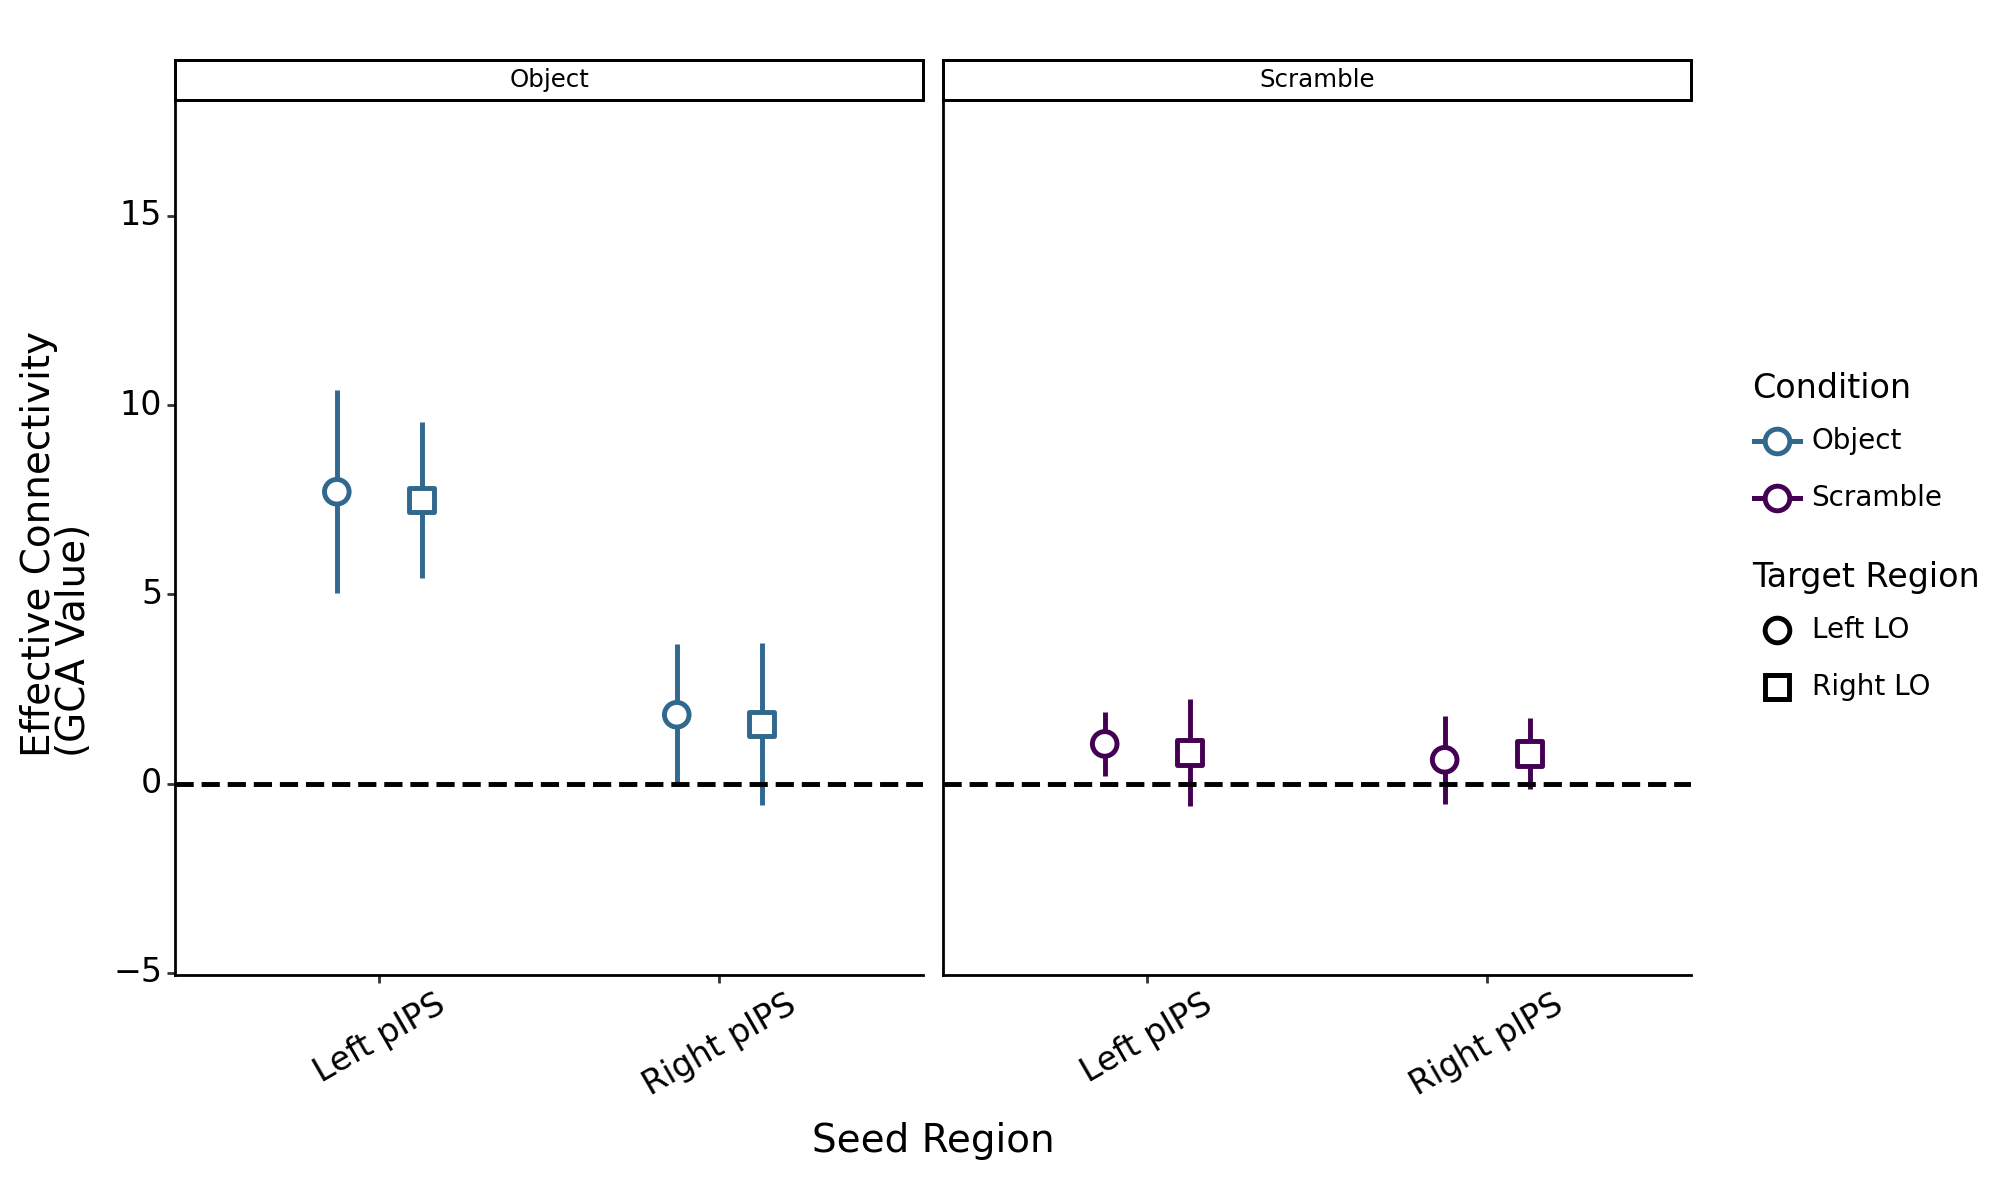

In [9]:
# exp 1 GCA plot
# File paths
base_dir = '/user_data/csimmon2/git_repos/ptoc'
results_dir = f"{base_dir}/results"
fig_dir = f"{results_dir}/gca"

import pandas as pd
import numpy as np
from plotnine import (ggplot, aes, geom_point, geom_linerange, theme_classic, 
                    ylim, xlab, ylab, theme, element_text, element_line, 
                    element_blank, scale_color_manual, position_dodge2, 
                    geom_hline, scale_shape_manual, labs, facet_wrap)

# Read the summary table
summary_table_combined = pd.read_csv(f"{fig_dir}/gca_summary_table_combined.csv")

# Create a plotting dataframe
plot_df = pd.DataFrame({
   'ROI': ['Left pIPS' if 'lpIPS' in x else 'Right pIPS' for x in summary_table_combined['origin']],
   'COND': ['Left LO' if 'lLO' in x else 'Right LO' for x in summary_table_combined['target']],
   'condition': summary_table_combined['condition'],
   'GC': summary_table_combined['Mean f_diff'],
   'SE': summary_table_combined['Std f_diff']/np.sqrt(19)  # Using n=19 subjects
})

# Make categorical variables
plot_df['ROI'] = pd.Categorical(plot_df['ROI'], categories=['Left pIPS', 'Right pIPS'], ordered=False)
plot_df['COND'] = pd.Categorical(plot_df['COND'], categories=['Left LO', 'Right LO'], ordered=False)
plot_df['condition'] = pd.Categorical(plot_df['condition'], categories=['Object', 'Scramble'], ordered=False)

# Create the plot
plot = (ggplot(plot_df, aes(x='ROI', y='GC', color='condition', shape='COND'))
       + geom_linerange(aes(ymin='GC - SE', ymax='GC + SE'), 
                       size=1, position=position_dodge2(width=0.5))
       + geom_point(size=4, fill='white', stroke=1, 
                   position=position_dodge2(width=0.5))
       + ylim(-4, 17)
       + scale_color_manual(values=['#31688E', '#440154'])
       + scale_shape_manual(values=['o', 's'])
       + theme_classic()
       + labs(color='Condition', shape='Target Region')
       + xlab('Seed Region')
       + ylab('Effective Connectivity \n(GCA Value)')
       + geom_hline(yintercept=0, linetype='dashed', size=1)
       + theme(
           text=element_text(color='black'),
           axis_text_x=element_text(angle=30, size=12),
           axis_text_y=element_text(size=12),
           axis_title=element_text(size=14),
           axis_line=element_line(),
           panel_border=element_blank(),
           legend_position="right",
           legend_box="vertical",
           legend_title=element_text(size=12),
           legend_text=element_text(size=10),
           figure_size=(10, 6)
       )
       + facet_wrap('~ condition'))

print(plot)

Calculating global scale...


Global value range: -16.13 to 18.42
Using scale: -18.42 to 18.42
Using threshold: 4.00


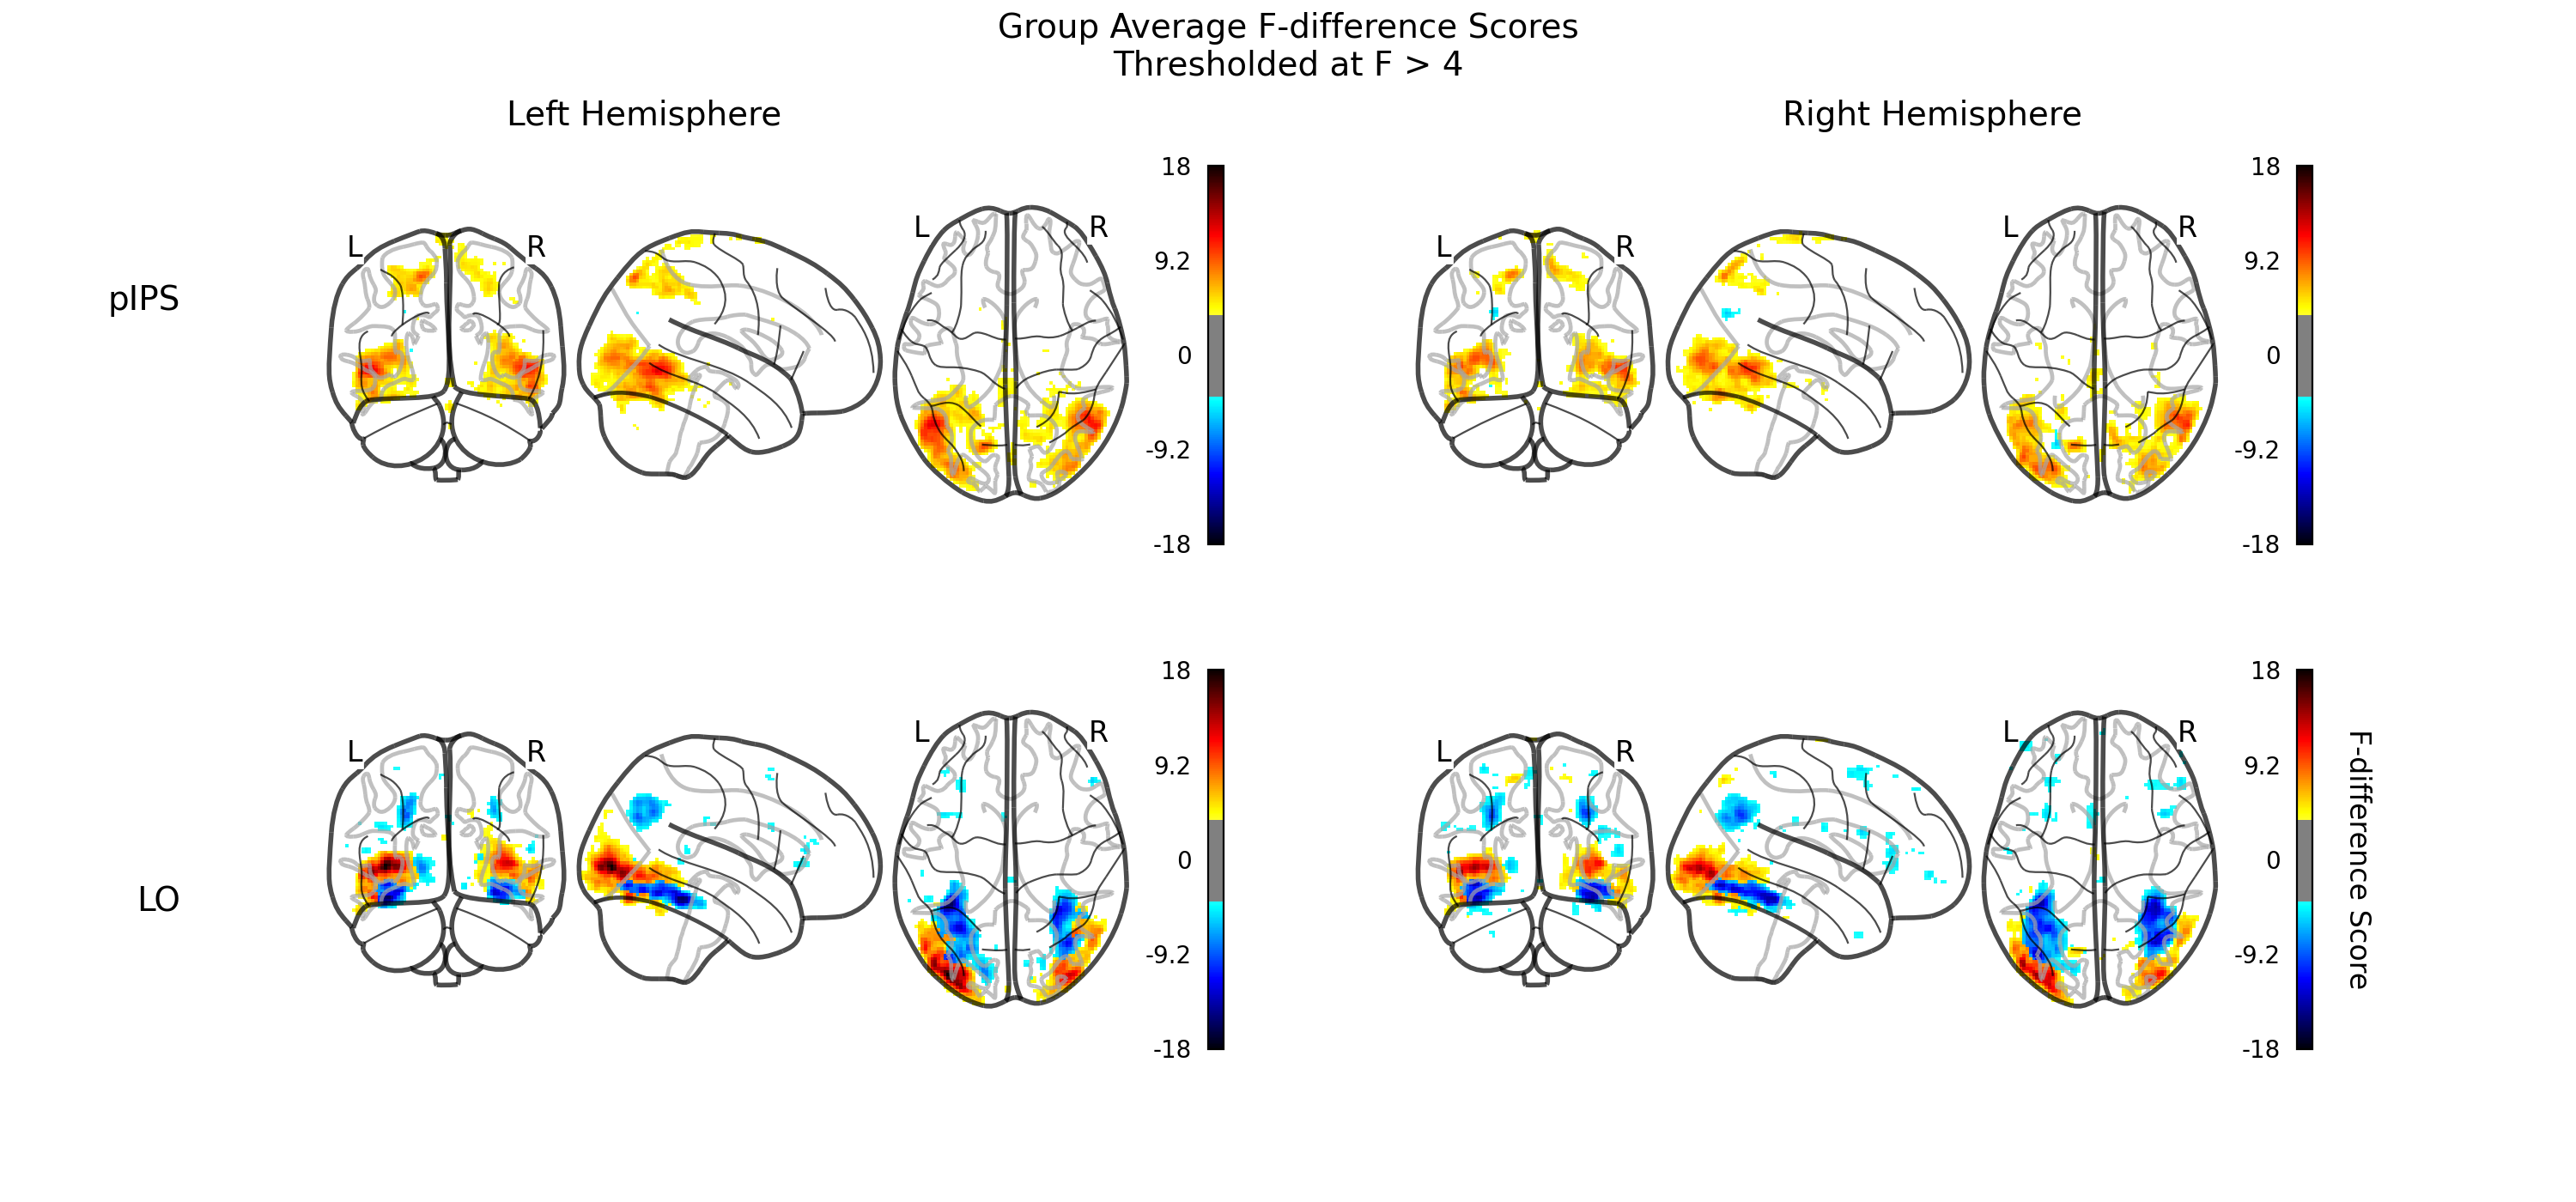


Processing complete.


In [31]:
# GCA Searchlight brain map - Exp 1
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting
import glob
import os
import re

def load_and_average(file_pattern):
    """Helper function to load and average files"""
    files = glob.glob(file_pattern)
    
    if not files:
        print(f"No files found matching the pattern: {file_pattern}")
        return None, None, []
    
    # Extract and sort subject numbers
    subject_files = {}
    for f in files:
        match = re.search(r'sub-(\d+)', f)
        if match:
            subject_files[match.group(1)] = f
    
    sorted_subjects = sorted(subject_files.keys(), key=int)
    
    # Load all images
    images = [nib.load(subject_files[subject]) for subject in sorted_subjects]
    
    # Check if all images have the same shape
    shapes = [img.shape for img in images]
    if len(set(shapes)) > 1:
        print("Error: Not all images have the same shape.")
        return None, None, []
    
    # Calculate the average
    avg_data = np.mean([img.get_fdata() for img in images], axis=0)
    avg_img = nib.Nifti1Image(avg_data, images[0].affine, images[0].header)
    
    return avg_data, avg_img, sorted_subjects

def find_global_scale(base_path, regions):
    """Find global min and max values across all group averages"""
    all_averages = []
    
    for region in regions:
        file_pattern = f'{base_path}/sub-*/ses-01/derivatives/gca/combined_object_{region}_mni.nii.gz'
        avg_data, _, _ = load_and_average(file_pattern)
        if avg_data is not None:
            all_averages.append(avg_data)
    
    if all_averages:
        global_min = min(np.min(avg) for avg in all_averages)
        global_max = max(np.max(avg) for avg in all_averages)
        return global_min, global_max
    return None, None

def create_2x2_brain_figure(base_path, regions, vmin, vmax, threshold):
    # Create figure with adjusted height
    fig = plt.figure(figsize=(15, 7))  # Slightly increased height for colorbar label
    
    # Add column labels (hemisphere labels)
    fig.text(0.25, 0.89, 'Left Hemisphere', ha='center', va='bottom', fontsize=14)
    fig.text(0.75, 0.89, 'Right Hemisphere', ha='center', va='bottom', fontsize=14)
    
    # Add row labels
    fig.text(0.07, 0.75, 'pIPS', ha='right', va='center', fontsize=14)
    fig.text(0.07, 0.25, 'LO', ha='right', va='center', fontsize=14)
    
    # Define the order for 2x2 layout
    region_order = ['pIPS_left', 'pIPS_right', 'LO_left', 'LO_right']
    
    # Create a list to store display objects
    displays = []
    
    for idx, region in enumerate(region_order):
        # Calculate subplot position (2x2 grid)
        ax = plt.subplot(2, 2, idx + 1)
        
        # Load and average data
        file_pattern = f'{base_path}/sub-*/ses-01/derivatives/gca/combined_object_{region}_mni.nii.gz'
        avg_data, avg_img, _ = load_and_average(file_pattern)
        
        if avg_img is None:
            continue
        
        # Save the average image
        output_path = f'group_average_{region}.nii.gz'
        nib.save(avg_img, output_path)
        
        # Display the brain with specific display settings
        display = plotting.plot_glass_brain(
            avg_img,
            threshold=threshold,
            colorbar=True,
            plot_abs=False,
            vmin=vmin,
            vmax=vmax,
            display_mode='ortho',
            axes=ax,
            black_bg=False,
            title=''  # Remove individual titles since we have row/column labels
        )
        displays.append(display)
    
    # Add colorbar label to the last display
    if displays:
        # Get the last colorbar axes
        last_display = displays[-1]
        if hasattr(last_display, '_cbar'):
            cbar = last_display._cbar
            # Update colorbar label
            cbar.set_label('F-difference Score', rotation=270, labelpad=25, fontsize=12)
    
    # Add a title for the entire figure
    fig.suptitle('Group Average F-difference Scores\nThresholded at F > {}'.format(threshold), 
                 y=.99, fontsize=14)
    
    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.4, hspace=0.3, top=0.9, bottom=0.1, left=0.1, right=0.9)
    
    plt.savefig('combined_brain_visualizations.png', dpi=300, bbox_inches='tight')
    plt.show()

# Base path
base_path = '/lab_data/behrmannlab/vlad/ptoc'

# First find global min and max
print("Calculating global scale...")
regions = ['pIPS_right', 'pIPS_left', 'LO_right', 'LO_left']
global_min, global_max = find_global_scale(base_path, regions)
print(f"Global value range: {global_min:.2f} to {global_max:.2f}")

# Set symmetric limits based on the absolute maximum value
sym_max = max(abs(global_min), abs(global_max))
vmin, vmax = -sym_max, sym_max
##to manually set the scales uncomment the following line
#vmin, vmax = -25, 25

# Set threshold
threshold = 4

print(f"Using scale: {vmin:.2f} to {vmax:.2f}")
print(f"Using threshold: {threshold:.2f}")

# Create the combined figure
create_2x2_brain_figure(base_path, regions, vmin=vmin, vmax=vmax, threshold=threshold)

print("\nProcessing complete.")

In [ ]:
# exp 2 GCA - extract values || I stopped running at ~ 366 mins. 
import pandas as pd
import nibabel as nib
import numpy as np
from nilearn import maskers
import os
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection

def get_roi_pairs():
   """Define all ROI pairs for analysis"""
   seeds = ['pIPS_left', 'pIPS_right']
   targets = ['LO_left', 'LO_right']
   pairs = []
   
   # Get both directions
   for seed in seeds:
       for target in targets:
           pairs.append((seed, target))  # pIPS → LO
           pairs.append((target, seed))  # LO → pIPS
           
   return pairs

def get_searchlight_values(subject_id, run_combo, seed_roi, target_roi, condition='tools'):
   """Extract values from searchlight maps using ROI coordinates"""
   coords_df = pd.read_csv('tools/roi_coordinates.csv')
   
   # Format ROI names to match coordinate file
   seed_prefix = 'l' if 'left' in seed_roi.lower() else 'r'
   seed_name = seed_roi.split('_')[0]  # get 'pIPS' from 'pIPS_left'
   seed_roi_coord_name = f"{seed_prefix}{seed_name}"
   
   # Get seed coordinates
   seed_coords = coords_df[
       (coords_df['subject'] == subject_id) &  
       (coords_df['run_combo'] == run_combo) & 
       (coords_df['roi'] == seed_roi_coord_name) &
       (coords_df['condition'] == condition)
   ]
   
   if seed_coords.empty:
       print(f"No coordinates found for seed {subject_id}, {seed_roi}, run combo {run_combo}")
       return None
       
   coord = (seed_coords['x'].iloc[0], seed_coords['y'].iloc[0], seed_coords['z'].iloc[0])
   
   # Load corresponding searchlight map
   run_pairs = {0: [1, 2], 1: [2, 1]}
   runs = run_pairs[run_combo]
   
   # The searchlight map filename uses the target ROI
   hemi = 'left' if 'left' in target_roi.lower() else 'right'
   roi = target_roi.split('_')[0]
   searchlight_path = f'/lab_data/behrmannlab/vlad/ptoc/{subject_id}/ses-01/derivatives/gca/searchlight_result_tool_runs{runs[0]}{runs[1]}_{roi}_{hemi}_1217.nii.gz'
   
   # Extract single value at coordinate
   roi_masker = maskers.NiftiSpheresMasker([coord], radius=6)
   values = roi_masker.fit_transform(searchlight_path)
   
   return values.ravel()[0]  # Return single GCA value

def extract_all_values():
   """Extract GCA values for all subjects and ROI pairs"""
   # Load subject information
   sub_info = pd.read_csv('/user_data/csimmon2/git_repos/ptoc/sub_info_tool.csv')
   subjects = sub_info[sub_info['exp'] == 'spaceloc']['sub'].tolist()  
   
   results = []
   roi_pairs = get_roi_pairs()
   
   for subject_id in subjects:
       for run_combo in [0, 1]:  # Cross-validation pairs
           for seed_roi, target_roi in roi_pairs:
               values = get_searchlight_values(subject_id, run_combo, seed_roi, target_roi)
               if values is not None:
                   results.append({
                       'subject': subject_id,  # Using 'subject' consistently in results
                       'run_combo': run_combo,
                       'seed_roi': seed_roi,
                       'target_roi': target_roi,
                       'gca_value': values
                   })
   
   return pd.DataFrame(results)

def calculate_cohens_d(mean_diff, std_diff):
   """Calculate Cohen's d as simple standardized mean difference"""
   return abs(mean_diff / std_diff)

def run_gca_stats(results_df):
   """Run statistical analysis matching experiment 1"""
   # First aggregate values across run_combos for each subject
   agg_df = results_df.groupby(['subject', 'seed_roi', 'target_roi'])['gca_value'].mean().reset_index()
   
   # Create summary table with means and standard deviations
   summary_table = pd.DataFrame()
   for seed in ['pIPS_left', 'pIPS_right']:
       for target in ['LO_left', 'LO_right']:
           data = agg_df[(agg_df['seed_roi'] == seed) & (agg_df['target_roi'] == target)]
           
           # Perform Wilcoxon test
           stat, p_value = stats.wilcoxon(data['gca_value'])
           
           summary_table = pd.concat([summary_table, pd.DataFrame({
               'origin': [seed],
               'target': [target],
               'Mean f_diff': [data['gca_value'].mean()],
               'Std f_diff': [data['gca_value'].std()],
               'p_value': [p_value]
           })])
   
   # Reset index
   summary_table = summary_table.reset_index(drop=True)
   
   # Apply FDR correction
   p_values = summary_table['p_value'].values
   rejected, p_corrected = fdrcorrection(p_values, alpha=0.05, method='indep')
   
   # Update table with FDR results
   summary_table['p_value_fdr'] = p_corrected
   summary_table['significant_fdr'] = rejected
   
   # Calculate Cohen's d
   print("\nCohen's d calculations:")
   for _, row in summary_table.iterrows():
       d = calculate_cohens_d(row['Mean f_diff'], row['Std f_diff'])
       print(f"{row['origin']}-{row['target']}: d = {d:.2f}")
       
   # Save results
   results_dir = '/user_data/csimmon2/git_repos/ptoc/results/gca'
   os.makedirs(results_dir, exist_ok=True)
   
   # Save summary table
   summary_table.to_csv(f"{results_dir}/gca_summary_table_tool_searchlight.csv", index=False)
   
   # Save detailed results
   with open(f"{results_dir}/gca_roi_pair_tool_searchlight_results_fdr.txt", 'w') as f:
       f.write("GCA ROI Pair Tool Searchlight Results (Wilcoxon tests):\n\n")
       for _, row in summary_table.iterrows():
           f.write(f"{row['origin']}-{row['target']}:\n")
           f.write(f"p_fdr = {row['p_value_fdr']:.4f}\n")
           f.write(f"significant = {row['significant_fdr']}\n\n")
   
   return summary_table

def main():
   """Main execution function"""
   print("Starting GCA analysis...")
   
   # Extract GCA values
   print("Extracting GCA values...")
   results_df = extract_all_values()
   
   # Save raw results
   results_dir = '/user_data/csimmon2/git_repos/ptoc/results/gca'
   os.makedirs(results_dir, exist_ok=True)
   results_df.to_csv(f"{results_dir}/gca_raw_values_tool_searchlight.csv", index=False)
   
   # Run statistical analysis
   print("Running statistical analysis...")
   summary_table = run_gca_stats(results_df)
   
   print("Analysis complete!")
   return results_df, summary_table

if __name__ == "__main__":
   results_df, summary_table = main()

In [14]:
# GCA hopefully shorter version exp 2 extraction [est. 6 hours]
import pandas as pd
import nibabel as nib
import numpy as np
from nilearn import maskers
import os
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection

def get_roi_pairs():
    """Define all ROI pairs for analysis"""
    seeds = ['pIPS_left', 'pIPS_right']
    targets = ['LO_left', 'LO_right']
    pairs = []
    
    for seed in seeds:
        for target in targets:
            pairs.append((seed, target))  # pIPS → LO
            pairs.append((target, seed))  # LO → pIPS
            
    return pairs

def get_searchlight_values(subject_id, run_combo, seed_roi, target_roi, condition='tools'):
    """Extract values from searchlight maps using ROI coordinates"""
    try:
        coords_df = pd.read_csv('tools/roi_coordinates.csv')
        
        # Format ROI names to match coordinate file
        seed_prefix = 'l' if 'left' in seed_roi.lower() else 'r'
        seed_name = seed_roi.split('_')[0]
        seed_roi_coord_name = f"{seed_prefix}{seed_name}"
        
        # Get seed coordinates
        seed_coords = coords_df[
            (coords_df['subject'] == subject_id) &  
            (coords_df['run_combo'] == run_combo) & 
            (coords_df['roi'] == seed_roi_coord_name) &
            (coords_df['condition'] == condition)
        ]
        
        if seed_coords.empty:
            return None
            
        coord = (seed_coords['x'].iloc[0], seed_coords['y'].iloc[0], seed_coords['z'].iloc[0])
        
        # Load corresponding searchlight map
        run_pairs = {0: [1, 2], 1: [2, 1]}
        runs = run_pairs[run_combo]
        
        hemi = 'left' if 'left' in target_roi.lower() else 'right'
        roi = target_roi.split('_')[0]
        searchlight_path = f'/lab_data/behrmannlab/vlad/ptoc/{subject_id}/ses-01/derivatives/gca/searchlight_result_tool_runs{runs[0]}{runs[1]}_{roi}_{hemi}_1217.nii.gz'
        
        if not os.path.exists(searchlight_path):
            return None
        
        roi_masker = maskers.NiftiSpheresMasker([coord], radius=6)
        values = roi_masker.fit_transform(searchlight_path)
        return values.ravel()[0]
        
    except Exception as e:
        print(f"Error processing {subject_id}, {seed_roi}, {target_roi}: {str(e)}")
        return None

def extract_all_values():
    """Extract GCA values for all subjects and ROI pairs"""
    # Load subject information
    sub_info = pd.read_csv('/user_data/csimmon2/git_repos/ptoc/sub_info_tool.csv')
    subjects = sub_info[sub_info['exp'] == 'spaceloc']['sub'].tolist()
    
    print(f"Processing {len(subjects)} subjects...")
    results = []
    roi_pairs = get_roi_pairs()
    total_combinations = len(subjects) * len(roi_pairs) * 2  # 2 for run_combos
    current = 0
    
    for subject_id in subjects:
        print(f"\nProcessing subject {subject_id}")
        for run_combo in [0, 1]:
            for seed_roi, target_roi in roi_pairs:
                current += 1
                if current % 10 == 0:  # Print progress every 10 combinations
                    print(f"Progress: {current}/{total_combinations}")
                
                values = get_searchlight_values(subject_id, run_combo, seed_roi, target_roi)
                if values is not None:
                    results.append({
                        'subject': subject_id,
                        'run_combo': run_combo,
                        'seed_roi': seed_roi,
                        'target_roi': target_roi,
                        'gca_value': values
                    })
    
    return pd.DataFrame(results)

def run_gca_stats(results_df):
    """Run statistical analysis matching experiment 1"""
    print("\nRunning statistical analysis...")
    
    # First aggregate values across run_combos for each subject
    agg_df = results_df.groupby(['subject', 'seed_roi', 'target_roi'])['gca_value'].mean().reset_index()
    
    # Create summary table with means and standard deviations
    summary_table = pd.DataFrame()
    for seed in ['pIPS_left', 'pIPS_right']:
        for target in ['LO_left', 'LO_right']:
            data = agg_df[(agg_df['seed_roi'] == seed) & (agg_df['target_roi'] == target)]
            
            # Perform Wilcoxon test
            stat, p_value = stats.wilcoxon(data['gca_value'])
            
            summary_table = pd.concat([summary_table, pd.DataFrame({
                'origin': [seed],
                'target': [target],
                'Mean f_diff': [data['gca_value'].mean()],
                'Std f_diff': [data['gca_value'].std()],
                'p_value': [p_value]
            })])
    
    summary_table = summary_table.reset_index(drop=True)
    
    # Apply FDR correction
    p_values = summary_table['p_value'].values
    rejected, p_corrected = fdrcorrection(p_values, alpha=0.05, method='indep')
    
    summary_table['p_value_fdr'] = p_corrected
    summary_table['significant_fdr'] = rejected
    
    # Calculate Cohen's d
    print("\nCohen's d calculations:")
    for _, row in summary_table.iterrows():
        d = calculate_cohens_d(row['Mean f_diff'], row['Std f_diff'])
        print(f"{row['origin']}-{row['target']}: d = {d:.2f}")
    
    return summary_table

def calculate_cohens_d(mean_diff, std_diff):
    """Calculate Cohen's d as simple standardized mean difference"""
    return abs(mean_diff / std_diff)

def main():
    """Main execution function"""
    print("Starting GCA analysis...")
    
    # Extract GCA values
    print("Extracting GCA values...")
    results_df = extract_all_values()
    
    # Save raw results
    results_dir = '/user_data/csimmon2/git_repos/ptoc/results/gca'
    os.makedirs(results_dir, exist_ok=True)
    results_df.to_csv(f"{results_dir}/gca_raw_values_tool_searchlight.csv", index=False)
    print(f"Raw results saved to {results_dir}/gca_raw_values_tool_searchlight.csv")
    
    # Run statistical analysis
    summary_table = run_gca_stats(results_df)
    
    # Save summary results
    summary_table.to_csv(f"{results_dir}/gca_summary_table_tool_searchlight.csv", index=False)
    print(f"Summary results saved to {results_dir}/gca_summary_table_tool_searchlight.csv")
    
    # Save detailed results
    with open(f"{results_dir}/gca_roi_pair_tool_searchlight_results_fdr.txt", 'w') as f:
        f.write("GCA ROI Pair Tool Searchlight Results (Wilcoxon tests):\n\n")
        for _, row in summary_table.iterrows():
            f.write(f"{row['origin']}-{row['target']}:\n")
            f.write(f"p_fdr = {row['p_value_fdr']:.4f}\n")
            f.write(f"significant = {row['significant_fdr']}\n\n")
    
    print("Analysis complete!")
    return results_df, summary_table

if __name__ == "__main__":
    results_df, summary_table = main()

Starting GCA analysis...
Extracting GCA values...


Processing 18 subjects...

Processing subject sub-spaceloc1001
Progress: 10/288

Processing subject sub-spaceloc1002
Progress: 20/288
Progress: 30/288

Processing subject sub-spaceloc1003
Progress: 40/288

Processing subject sub-spaceloc1004
Progress: 50/288
Progress: 60/288

Processing subject sub-spaceloc1005
Progress: 70/288
Progress: 80/288

Processing subject sub-spaceloc1006
Progress: 90/288

Processing subject sub-spaceloc1007
Progress: 100/288
Progress: 110/288

Processing subject sub-spaceloc1008
Progress: 120/288

Processing subject sub-spaceloc1009
Progress: 130/288
Progress: 140/288

Processing subject sub-spaceloc1010
Progress: 150/288
Progress: 160/288

Processing subject sub-spaceloc1011
Progress: 170/288

Processing subject sub-spaceloc1012
Progress: 180/288
Progress: 190/288

Processing subject sub-spaceloc2013
Progress: 200/288

Processing subject sub-spaceloc2014
Progress: 210/288
Progress: 220/288

Processing subject sub-spaceloc2015
Progress: 230/288
Progress: 240/

In [15]:
import pandas as pd
import nibabel as nib
import numpy as np
from nilearn import maskers

# Check coordinates
coords_df = pd.read_csv('tools/roi_coordinates.csv')
print("\nCoordinate file structure:")
print(coords_df.columns)

# Look at one specific case (e.g., first subject, pIPS predicting LO)
subject = 'sub-spaceloc1001'
run_combo = 0
seed_roi = 'pIPS_right'
target_roi = 'LO_left'

# Get seed coordinates
seed_prefix = 'r' if 'right' in seed_roi.lower() else 'l'
seed_name = seed_roi.split('_')[0]
seed_roi_coord_name = f"{seed_prefix}{seed_name}"

print(f"\nLooking for coordinates with:")
print(f"subject: {subject}")
print(f"run_combo: {run_combo}")
print(f"roi: {seed_roi_coord_name}")

seed_coords = coords_df[
    (coords_df['subject'] == subject) &  
    (coords_df['run_combo'] == run_combo) & 
    (coords_df['roi'] == seed_roi_coord_name)
]

print("\nFound coordinates:")
print(seed_coords)

# Check searchlight map path
run_pairs = {0: [1, 2], 1: [2, 1]}
runs = run_pairs[run_combo]

hemi = 'left' if 'left' in target_roi.lower() else 'right'
roi = target_roi.split('_')[0]
searchlight_path = f'/lab_data/behrmannlab/vlad/ptoc/{subject}/ses-01/derivatives/gca/searchlight_result_tool_runs{runs[0]}{runs[1]}_{roi}_{hemi}_1217.nii.gz'

print(f"\nChecking searchlight map:")
print(searchlight_path)
print(f"File exists: {os.path.exists(searchlight_path)}")

if os.path.exists(searchlight_path):
    # Load map and check value at coordinate
    coord = (seed_coords['x'].iloc[0], seed_coords['y'].iloc[0], seed_coords['z'].iloc[0])
    roi_masker = maskers.NiftiSpheresMasker([coord], radius=6)
    values = roi_masker.fit_transform(searchlight_path)
    print(f"\nExtracted value: {values.ravel()[0]}")


Coordinate file structure:
Index(['subject', 'run_combo', 'task', 'condition', 'roi', 'hemisphere', 'x',
       'y', 'z'],
      dtype='object')

Looking for coordinates with:
subject: sub-spaceloc1001
run_combo: 0
roi: rpIPS

Found coordinates:
             subject  run_combo     task        condition    roi hemisphere  \
1   sub-spaceloc1001          0  ToolLoc            tools  rpIPS          r   
9   sub-spaceloc1001          0  ToolLoc         scramble  rpIPS          r   
17  sub-spaceloc1001          0  ToolLoc         nontools  rpIPS          r   
25  sub-spaceloc1001          0  ToolLoc  toolovernontool  rpIPS          r   
33  sub-spaceloc1001          0  ToolLoc  nontoolovertool  rpIPS          r   

            x          y          z  
1   22.057859 -56.639176  53.665296  
9   20.096497 -58.414555  48.328882  
17  25.983629 -60.438867  44.968502  
25  26.030704 -55.078266  52.658788  
33  26.030704 -55.078266  52.658788  

Checking searchlight map:
/lab_data/behrmannlab/v

In [16]:
import pandas as pd
import nibabel as nib
import numpy as np
from nilearn import maskers
import os

# Check coordinates
coords_df = pd.read_csv('tools/roi_coordinates.csv')

# Look at one specific case
subject = 'sub-spaceloc1001'
run_combo = 0
seed_roi = 'pIPS_right'
target_roi = 'LO_left'
condition = 'tools'  # explicitly specify tools condition

# Get seed coordinates
seed_prefix = 'r' if 'right' in seed_roi.lower() else 'l'
seed_name = seed_roi.split('_')[0]
seed_roi_coord_name = f"{seed_prefix}{seed_name}"

print(f"\nLooking for coordinates with:")
print(f"subject: {subject}")
print(f"run_combo: {run_combo}")
print(f"roi: {seed_roi_coord_name}")
print(f"condition: {condition}")

seed_coords = coords_df[
    (coords_df['subject'] == subject) &  
    (coords_df['run_combo'] == run_combo) & 
    (coords_df['roi'] == seed_roi_coord_name) &
    (coords_df['condition'] == condition)  # add condition filter
]

print("\nFound coordinates:")
print(seed_coords)

# Check searchlight map path
run_pairs = {0: [1, 2], 1: [2, 1]}
runs = run_pairs[run_combo]

hemi = 'left' if 'left' in target_roi.lower() else 'right'
roi = target_roi.split('_')[0]
searchlight_path = f'/lab_data/behrmannlab/vlad/ptoc/{subject}/ses-01/derivatives/gca/searchlight_result_tool_runs{runs[0]}{runs[1]}_{roi}_{hemi}_1217.nii.gz'

print(f"\nChecking searchlight map:")
print(searchlight_path)
print(f"File exists: {os.path.exists(searchlight_path)}")

if os.path.exists(searchlight_path):
    coord = (seed_coords['x'].iloc[0], seed_coords['y'].iloc[0], seed_coords['z'].iloc[0])
    print(f"\nUsing coordinates: {coord}")
    roi_masker = maskers.NiftiSpheresMasker([coord], radius=6)
    values = roi_masker.fit_transform(searchlight_path)
    print(f"Extracted value: {values.ravel()[0]}")


Looking for coordinates with:
subject: sub-spaceloc1001
run_combo: 0
roi: rpIPS
condition: tools

Found coordinates:
            subject  run_combo     task condition    roi hemisphere  \
1  sub-spaceloc1001          0  ToolLoc     tools  rpIPS          r   

           x          y          z  
1  22.057859 -56.639176  53.665296  

Checking searchlight map:
/lab_data/behrmannlab/vlad/ptoc/sub-spaceloc1001/ses-01/derivatives/gca/searchlight_result_tool_runs12_LO_left_1217.nii.gz
File exists: True

Using coordinates: (22.05785897660016, -56.63917624174629, 53.66529624382832)
Extracted value: -0.3787620108998905


In [ ]:
# exp 2 GCA - stats

In [ ]:
# exp 2 GCA - figures